# Mount the drive

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls drive/'My Drive'/'Colab Notebooks'

 03_CGAN_MNIST.ipynb		   'SCGAN (1).v1.ipynb'
'Chapter_7_SGAN (1).ipynb'	    SCGAN-3D.test
'Chapter_7_SGAN (2).ipynb'	    SCGAN.3D.v0.ipynb
 Chapter_7_SGAN.ipynb		    SCGAN-3D.v1.1000.ipynb
 Chapter_8_CGAN.ipynb		    SCGAN-3D.v2.1000.ipynb
'Chapter_8_CGAN - 副本 (1).ipynb'   SCGAN-3D.v4.2880.undone.ipynb
'Chapter_8_CGAN - 副本.ipynb'	   'SCGAN-3D.v4.960 (1).ipynb'
 dcgan.ipynb			    SCGAN-3D.v4.960.ipynb
 full_dataset_vectors.h5	    SCGAN-3D.v5.ipynb
 GAN-tmp.ipynb			    SCGAN.v1.ipynb
 mean-teacher-master		    SSGAN-Tensorflow-master
'mean teacher.v0.mine.ipynb'	    Untitled0.ipynb
'Mean Teacher.v1.ipynb'		    Untitled1.ipynb


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import json
import time
import h5py
import math

import plotly.graph_objs as go
from matplotlib.pyplot import cm
import plotly.graph_objs as go

import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape, Embedding,
                          Multiply, MaxPool3D)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D, Conv3DTranspose
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.backend import epsilon

# Process data

In [0]:
with h5py.File('drive/My Drive/Colab Notebooks/full_dataset_vectors.h5', 'r') as mnist3d:
    x_train = mnist3d["X_train"][:]
    x_test = mnist3d["X_test"][:]
    y_train = mnist3d["y_train"][:]
    y_test = mnist3d["y_test"][:]

In [30]:
print ("x_train shape: "+str(x_train.shape))
print ("y_train shape: "+str(y_train.shape))
print ("x_test shape:  "+str(x_test.shape))
print ("y_test shape:  "+str(y_test.shape))

x_train shape: (10000, 4096)
y_train shape: (10000,)
x_test shape:  (2000, 4096)
y_test shape:  (2000,)


In [31]:
# Split the data
x = np.vstack((x_train, x_test))
y = np.hstack((y_train, y_test))
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9600, 4096)
(9600,)
(2400, 4096)
(2400,)


In [0]:
## Introduce the channel dimension in the input dataset , just shape, no data
xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

## iterate in train and test, add the rgb dimention 
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array
for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])

## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

## convert target variable into one-hot
ytrain = to_categorical(y_train, num_classes=10)
ytest = to_categorical(y_test, num_classes=10)

In [33]:
print ("xtrain shape: "+str(xtrain.shape))
print ("ytrain shape: "+str(ytrain.shape))
print ("xtest shape:  "+str(xtest.shape))
print ("ytest shape:  "+str(ytest.shape))

xtrain shape: (9600, 16, 16, 16, 3)
ytrain shape: (9600, 10)
xtest shape:  (2400, 16, 16, 16, 3)
ytest shape:  (2400, 10)


In [0]:
class Dataset:
    def __init__(self, num_labeled):
        self.num_labeled = num_labeled
        self.x_train = xtrain
        self.y_train = ytrain
        self.x_test = xtest
        self.y_test = ytest

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        # x_train = self.x_train[range(self.num_labeled)]
        # y_train = self.y_train[range(self.num_labeled)]
        return self.x_train, self.y_train

    def test_set(self):
        return self.x_test, self.y_test

# Number of labeled data

In [0]:
num_labeled = 120    # Number of labeled examples to use (rest will be used as unlabeled)

In [181]:
%mkdir models
%mkdir losses
%mkdir models/models-label-120
%mkdir losses/losses-label-120

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘losses’: File exists


# SCGAN

## Build the model

In [0]:
img_rows = 16
img_cols = 16
img_deps = 16
channels = 3

# Input image dimensions
img_shape = (img_rows, img_cols, img_deps, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

In [0]:
def build_generator(z_dim):
  
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ), dtype='float32')
    label_embedding = Dense(z_dim, input_dim=num_classes)(label)
    joined_representation = Multiply()([z, label_embedding])
    
#     model = Sequential()

    # Reshape input into 4x4x4x256 tensor via a fully connected layer
    model = Dense(256 * 4 * 4 * 4, input_dim=z_dim)(joined_representation)
    model = Reshape((4, 4, 4, 256))(model)

    # Transposed convolution layer, from 4x4x4x256 into 8x8x8x128 tensor
    model = Conv3DTranspose(128, kernel_size=3, strides=2, padding='same')(model)

    # Batch normalization
    model = BatchNormalization()(model)

    # Leaky ReLU activation
    model = LeakyReLU(alpha=0.01)(model)

    # Transposed convolution layer, from 8x8x8x128 to 8x8x8x64 tensor
    model = Conv3DTranspose(64, kernel_size=3, strides=1, padding='same')(model)

    # Batch normalization
    model = BatchNormalization()(model)

    # Leaky ReLU activation
    model = LeakyReLU(alpha=0.01)(model)

    # Transposed convolution layer, from 8x8x8x64 to 16x16x16x3 tensor
    model = Conv3DTranspose(3, kernel_size=3, strides=2, padding='same')(model)

    # Output layer with tanh activation
    conditioned_img = Activation('tanh')(model)
    
#     conditioned_img = model(joined_representation)

    model = Model([z, label], conditioned_img)

    return model

In [0]:
build_generator(z_dim).summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          1100        input_2[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 100)          0           input_1[0][0]                    
                                                                 dense_1[0][0]          

In [0]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # Convolutional layer, from 16x16x16x3 into 8x8x8x8 tensor
    model.add(Conv3D(8, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 8x8x8x8 into 4x4x4x16 tensor
    model.add(Conv3D(32, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))

    # Convolutional layer, from 4x4x4x16 tensor into 2x2x2x32 tensor
    model.add(Conv3D(32, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))

    # Convolutional layer, from 2x2x2x32 tensor into 1x1x1x64 tensor
    model.add(Conv3D(64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(num_classes))

    # img = Input(shape=img_shape)
    # output = model(img)

    # return Model(img, output)

    return model

In [0]:
# More complex discriminator

# def build_discriminator_net(img_shape):
    
#     model = Sequential()

#     model.add(Conv3D(filters=8, kernel_size=(3, 3, 3), use_bias=False, , input_shape=img_shapepadding='Same'))
#     model.add(BatchNormalization())
#     model.add(Activation("relu"))
#     model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), use_bias=False, padding='Same'))
#     model.add(BatchNormalization())
#     model.add(Activation("relu"))

#     model.add(MaxPool3D(pool_size=(2, 2, 2))) # the pool_size (2, 2, 2) halves the size of its input

#     model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), use_bias=False, padding='Same'))
#     model.add(BatchNormalization())
#     model.add(Activation("relu"))
#     model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), use_bias=False, padding='Same'))
#     model.add(BatchNormalization())
#     model.add(Activation("relu"))

#     ## Pooling layer
#     model.add(MaxPool3D(pool_size=(2, 2, 2)))
#     model.add(Dropout(0.25)) #No more BatchNorm after this layer because we introduce Dropout

#     model.add(Flatten())

#     ## Dense layers
#     model.add(Dense(units=4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(units=1024, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(units=10, activation='softmax'))

#     return model

In [0]:
build_discriminator_net(img_shape).summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 8, 8, 8, 8)        656       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 8, 8)        0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 4, 4, 32)       6944      
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 4, 32)       128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4, 4, 4, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 4, 32)       0         
_____

In [0]:
def build_discriminator_class(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    # img = Input(shape=img_shape)
    # output = model(img)

    # return Model(img, output)

    return model

In [0]:
def build_discriminator_realOrFake(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    # img = Input(shape=img_shape)
    # output = model(img)

    # return Model(img, output)

    return model

In [0]:
def build_gan(generator, discriminator):

    # discriminator.trainable = False
    
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ))
    img = generator([z, label])
    output = discriminator(img)
    model = Model([z, label], output)

    # model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam())

    return model

In [0]:
def build_gan_class(generator, discriminator):

    discriminator.trainable = False
    
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ))
    img = generator([z, label])
    output = discriminator(img)
    model = Model([z, label], output)

    # model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

    return model

In [0]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training

discriminator_net = build_discriminator_net(img_shape)

discriminator_realOrFake = build_discriminator_realOrFake(discriminator_net)
discriminator_realOrFake.trainable = True
discriminator_realOrFake.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam())

discriminator_class = build_discriminator_class(discriminator_net)
discriminator_class.trainable = True
discriminator_class.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

In [0]:
# Build the Generator
generator = build_generator(z_dim)

# gan_realOrFake = build_gan_realOrFake(generator, discriminator_realOrFake)
# gan_class = build_gan_class(generator, discriminator_class)
# gan_realOrFake.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam())
# gan_class.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

discriminator_realOrFake.trainable = False
discriminator_class.trainable = False

gan_realOrFake = build_gan(generator, discriminator_realOrFake)
gan_realOrFake.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam())

gan_class = build_gan(generator, discriminator_class)
gan_class.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

In [44]:
discriminator_realOrFake.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 10)                91802     
_________________________________________________________________
lambda_2 (Lambda)            (None, 1)                 0         
Total params: 183,348
Trainable params: 91,546
Non-trainable params: 91,802
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning:

Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?



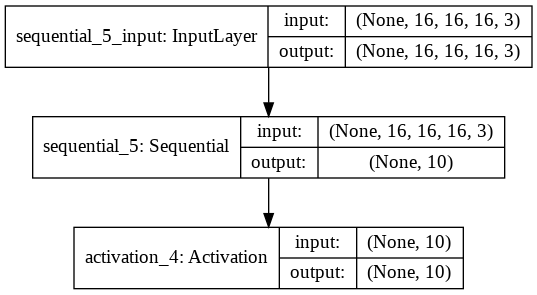

In [46]:
plot_model(discriminator_class,to_file="./models/model_discriminator_class.png",show_shapes=True)

In [47]:
discriminator_class.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 10)                91802     
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total params: 183,348
Trainable params: 91,546
Non-trainable params: 91,802
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning:

Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?



In [48]:
gan_realOrFake.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 16, 16, 16, 3 2767951     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1)            91802       model_5[1][0]              

In [49]:
gan_class.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 16, 16, 16, 3 2767951     input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 10)           91802       model_5[2][0]              

In [50]:
generator.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 100)          1100        input_10[0][0]                   
__________________________________________________________________________________________________
multiply_3 (Multiply)           (None, 100)          0           input_9[0][0]                    
                                                                 dense_8[0][0]              

## Training

In [0]:
def pretrain(iterations_pre, batch_size, save_interval):
  for iteration in range(iterations_pre):
      # imgs_labeled, labels = dataset.training_set()
      imgs_labeled, labels = dataset.batch_labeled(1000)
      loss_d_labeled_class, acc_d_labeled_class = discriminator_class.train_on_batch(imgs_labeled, labels)
      if (iteration + 1) % save_interval == 0:
          
          # Output training progress
          print(
              "%d [D loss class: %.4f, acc: %.2f%%]"
              % (iteration + 1, loss_d_labeled_class, 100 * acc_d_labeled_class))
          
          discriminator_class.save("./models/discriminator_class-" + str(iteration+1) + ".h5")
          
          # x, y = dataset.training_set()
          # _, accuracy = discriminator_class.evaluate(x, y)
          # print("Training Accuracy: %.2f%%" % (100 * accuracy))      

In [185]:
# Set hyperparameters
iterations_pre = 2000 # 2000
batch_size = 32
save_interval = 100
# num_labeled = 1920

dataset = Dataset(num_labeled)

discriminator_class.trainable = True
# discriminator_class.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

pretrain(iterations_pre, batch_size, save_interval)

100 [D loss class: 0.0106, acc: 99.70%]
200 [D loss class: 0.0129, acc: 99.70%]
300 [D loss class: 0.0071, acc: 99.80%]
400 [D loss class: 0.0086, acc: 99.60%]
500 [D loss class: 0.0072, acc: 99.90%]
600 [D loss class: 0.0091, acc: 99.90%]
700 [D loss class: 0.0113, acc: 99.60%]
800 [D loss class: 0.0096, acc: 99.80%]
900 [D loss class: 0.0085, acc: 99.90%]
1000 [D loss class: 0.0131, acc: 99.60%]
1100 [D loss class: 0.0065, acc: 99.90%]
1200 [D loss class: 0.0062, acc: 99.90%]
1300 [D loss class: 0.0061, acc: 100.00%]
1400 [D loss class: 0.0038, acc: 99.90%]
1500 [D loss class: 0.0021, acc: 100.00%]
1600 [D loss class: 0.0058, acc: 99.90%]
1700 [D loss class: 0.0055, acc: 100.00%]
1800 [D loss class: 0.0048, acc: 99.90%]
1900 [D loss class: 0.0052, acc: 99.90%]
2000 [D loss class: 0.0117, acc: 99.60%]


In [186]:
x, y = dataset.test_set()
_, accuracy = discriminator_class.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

2400/2400 [==============================] - 0s 145us/step
Test Accuracy: 53.29%


2400/2400 [==============================] - 0s 173us/step
0.5416666666666666


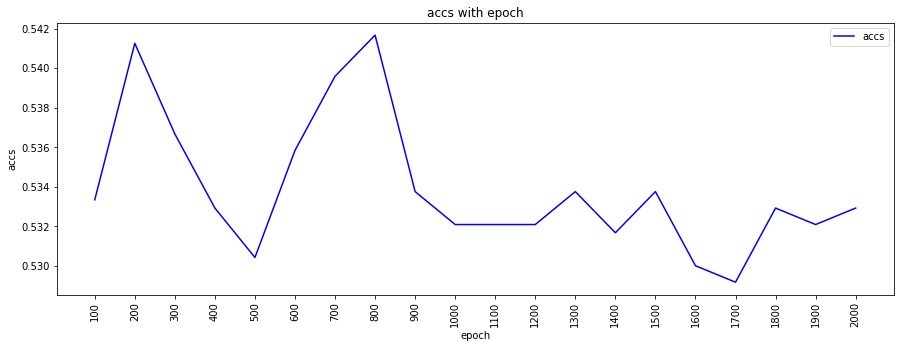

In [187]:
accs = []
tx = [x for x in range(100,2100,100)]
acc_max = [0,0]

tmodel = build_discriminator_class(build_discriminator_net(img_shape))
tmodel.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

for e in tx:
  tmodel.load_weights("./models/discriminator_class-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("accs with epoch")
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

In [0]:
def train(iterations, batch_size, save_interval, m, n):


    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        for _ in range(m):

            # -------------------------
            #  Train the Discriminator
            # -------------------------


            # Get labeled examples
            imgs_labeled, labels = dataset.batch_labeled(batch_size)

            # Get unlabeled examples
            imgs_unlabeled = dataset.batch_unlabeled(batch_size)

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
            fake_labels = to_categorical(fake_labels, num_classes=num_classes)
            imgs_gen = generator.predict([z, fake_labels])

            discriminator_realOrFake.trainable = True
            discriminator_class.trainable = True

            # Train discriminator
            loss_d_labeled_realOrFake, acc_d_labeled_realOrFake = discriminator_realOrFake.train_on_batch(imgs_labeled, real)
            loss_d_unlabeled_realOrFake, acc_d_unlabeled_realOrFake = discriminator_realOrFake.train_on_batch(imgs_unlabeled, real)
            loss_d_gen_realOrFake, acc_d_gen_realOrFake = discriminator_realOrFake.train_on_batch(imgs_gen, fake)
            loss_d_labeled_class, acc_d_labeled_class = discriminator_class.train_on_batch(imgs_labeled, labels)
            # loss_d_gen_class, acc_d_gen_class = discriminator_class.train_on_batch(imgs_gen, fake_labels)

            # Calculate loss and acc
            # loss_d_train_realOrFake = np.add(loss_d_labeled_realOrFake, loss_d_unlabeled_realOrFake)
            # loss_d_class = np.add(loss_d_labeled_class, loss_d_gen_class)
            loss_d_class = loss_d_labeled_class
            loss_d_realOrFake = np.add(loss_d_gen_realOrFake, np.add(loss_d_labeled_realOrFake, loss_d_unlabeled_realOrFake))
            loss_d = np.add(loss_d_class, loss_d_realOrFake)
            # acc_d_class = np.add(acc_d_labeled_class, acc_d_gen_class)/2.0
            acc_d_class = acc_d_labeled_class
            acc_d_realOrFake = np.add(acc_d_gen_realOrFake, np.add(acc_d_labeled_realOrFake, acc_d_unlabeled_realOrFake))/3.0
            acc_d = np.add(acc_d_class, acc_d_realOrFake)/2.0

        for _ in range(n):

            # ---------------------
            #  Train the Generator
            # ---------------------

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
            fake_labels = to_categorical(fake_labels, num_classes=num_classes)

            discriminator_realOrFake.trainable = False
            discriminator_class.trainable = False

            # Train Generator
            loss_g_realOrFake, acc_g_realOrFake = gan_realOrFake.train_on_batch([z, fake_labels], fake)
            # loss_g_class, acc_g_class = gan_class.train_on_batch([z, fake_labels], fake_labels)

            # Calculate loss
            # loss_g = np.add(loss_g_realOrFake, loss_g_class)
            loss_g = losses_g_realOrFake

        if (iteration + 1) % save_interval == 0:

            # Save Discriminator supervised classification loss to be plotted after training
            losses_d_class.append(loss_d_class)
            losses_d_realOrFake.append(loss_d_realOrFake)
            # losses_g_class.append(loss_g_class)
            losses_g_realOrFake.append(loss_g_realOrFake)
            
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss class: %.4f, acc: %.2f%%] [D loss realOrFake: %.4f, acc:%.2f%%] [G loss realOrFake: %.4f, acc: %.2f%%]"
                % (iteration + 1, 
                    loss_d_class, 100 * acc_d_class,
                    loss_d_realOrFake, 100 * acc_d_realOrFake, 
                    # loss_g_class, 100 * acc_g_class,
                    loss_g_realOrFake, 100 * acc_g_realOrFake))
            
            discriminator_class.save("./models/models-label-" + str(num_labeled) + "/discriminator_class-" + str(iteration+1) + ".h5")
            discriminator_realOrFake.save("./models/models-label-" + str(num_labeled) + "/discriminator_realOrFake-" + str(iteration+1) + ".h5")
            generator.save("./models/models-label-" + str(num_labeled) + "/generator-" + str(iteration+1) + ".h5")
            file1 = "./losses/losses-label-" + str(num_labeled) + "/losses_d_class.json"
            file2 = "./losses/losses-label-" + str(num_labeled) + "/losses_d_realOrFake.json"
            # file3 = "./losses/losses-label-" + str(num_labeled) + "/losses_g_class.json"
            file4 = "./losses/losses-label-" + str(num_labeled) + "/losses_g_realOrFake.json"
            with open(file1, 'w') as json_file:
                  json.dump(str(losses_d_class), json_file)
            with open(file2, 'w') as json_file:
                  json.dump(str(losses_d_realOrFake), json_file)
            # with open(file3, 'w') as json_file:
            #       json.dump(str(losses_g_class), json_file)
            with open(file4, 'w') as json_file:
                  json.dump(str(losses_g_realOrFake), json_file)
            
            # x,y = dataset.training_set()
            # _, acc = discriminator_class.evaluate(x,y)
            # print(str(100*acc)+"%")

In [189]:
# Set hyperparameters
iterations = 8000 # 8000
batch_size = 32
save_interval = 100
# num_labeled = 960  # Number of labeled examples to use (rest will be used as unlabeled)
m = 1 # iteration of Discriminator
n = 1 # iteration of Generator

losses_d_class = []
losses_d_realOrFake = []
losses_d = []
losses_g_realOrFake = []
losses_g_class = []
losses_g = []

iteration_checkpoints = []

discriminator_class = load_model("./models/discriminator_class-800.h5")
starttime = time.clock()

# Train the SCGAN for the specified number of iterations
train(iterations, batch_size, save_interval, m, n)

endtime = time.clock()
print("Training time: %.4fs" % (endtime - starttime))

100 [D loss class: 0.1004, acc: 96.88%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
200 [D loss class: 0.0015, acc: 100.00%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
300 [D loss class: 0.1054, acc: 96.88%] [D loss realOrFake: 0.0003, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
400 [D loss class: 0.0361, acc: 100.00%] [D loss realOrFake: 0.0012, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
500 [D loss class: 0.1056, acc: 93.75%] [D loss realOrFake: 0.0002, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
600 [D loss class: 0.0086, acc: 100.00%] [D loss realOrFake: 0.0001, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
700 [D loss class: 0.0338, acc: 100.00%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
800 [D loss class: 0.0032, acc: 100.00%] [D loss realOrFake: 0.0012, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
900 [D loss

## Evaluate

In [190]:
x, y = dataset.training_set()

# tmodel = load_model("./models/models-label-" + str(num_labeled) + "/discriminator_class-8000.h5")   # Take too much time
tmodel = build_discriminator_class(build_discriminator_net(img_shape))
tmodel.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_class-8000.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
# _, accuracy = discriminator_class.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

9600/9600 [==============================] - 5s 516us/step
Training Accuracy: 51.09%


In [191]:
x, y = dataset.test_set()

# tmodel = keras.models.load_model("./models/models-label-" + str(num_labeled) + "/discriminator_class-5700.h5")
# tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_class-8000.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
# _, accuracy = discriminator_class.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

2400/2400 [==============================] - 0s 172us/step
Training Accuracy: 45.17%


2400/2400 [==============================] - 0s 167us/step
0.5325
0.5325
0.5325


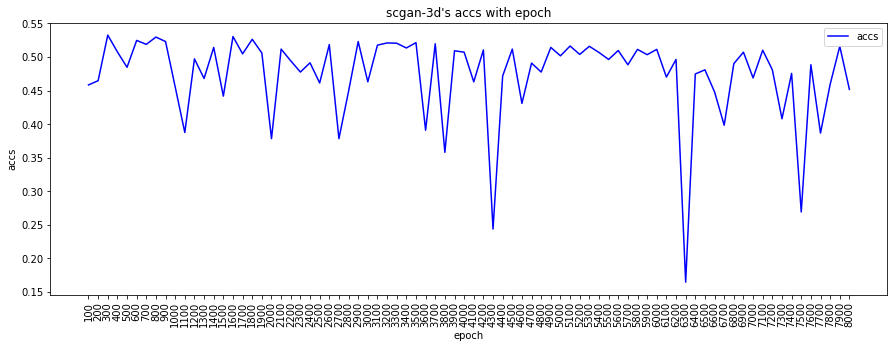

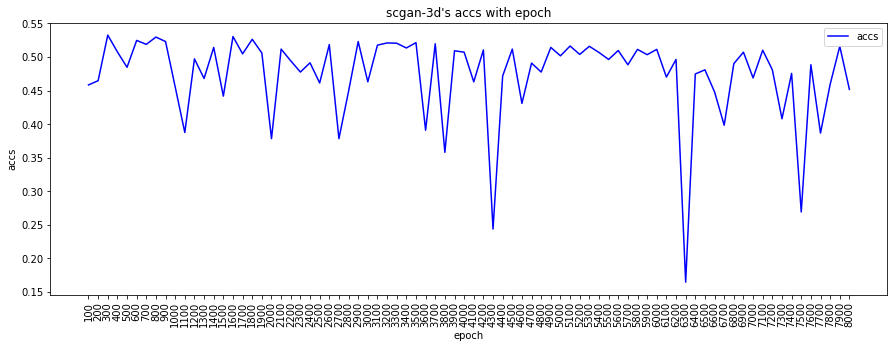

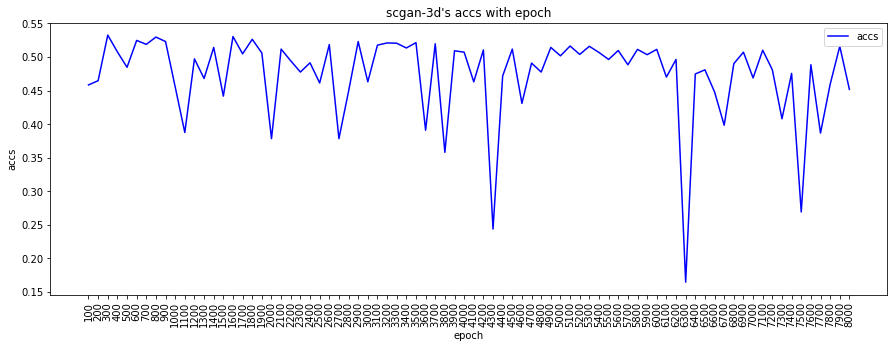

In [192]:
accs = []
tx = [x for x in range(100,8100,100)]
acc_max = [0,0]

for e in tx:
  # tmodel = load_model("./models/models-label-" + str(num_labeled) + "/discriminator_class-"+ str(e) +".h5")
  tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_class-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("scgan-3d's accs with epoch")
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

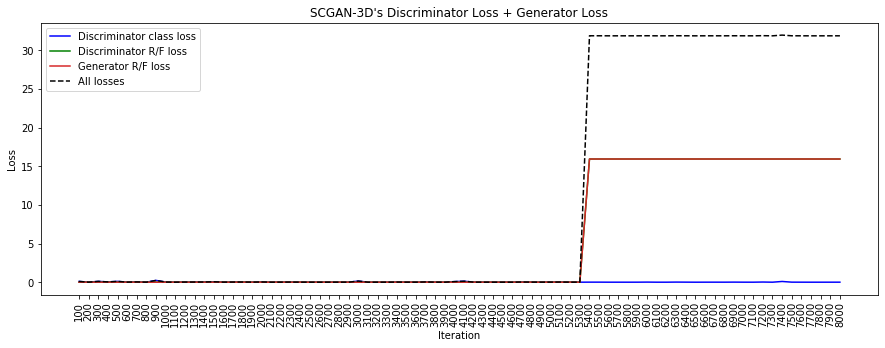

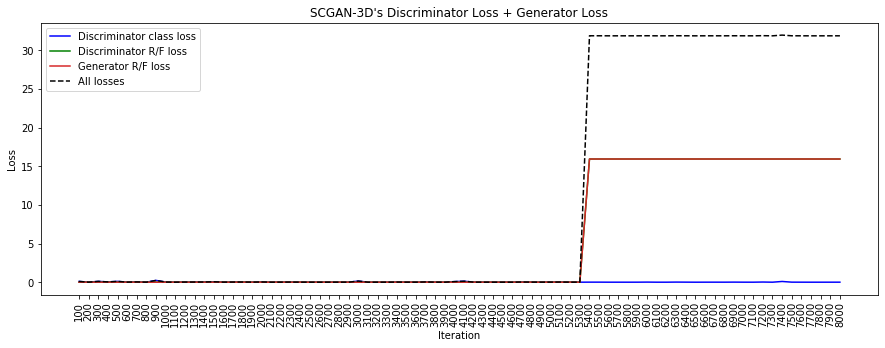

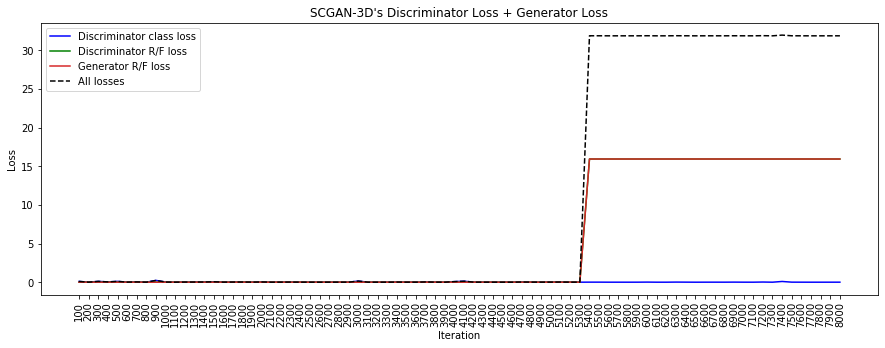

In [193]:
d_class_loss = np.array(losses_d_class)
d_realOrFake_loss = np.array(losses_d_realOrFake)
# g_class_loss = np.array(losses_g_class)
g_realOrFake_loss = np.array(losses_g_realOrFake)
# class_loss = np.add(d_class_loss, g_class_loss)
all_loss = np.add(g_realOrFake_loss, np.add(d_class_loss, d_realOrFake_loss))

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, d_class_loss, label="Discriminator class loss", color='blue')
plt.plot(iteration_checkpoints, d_realOrFake_loss, label="Discriminator R/F loss", color='green')
# plt.plot(iteration_checkpoints, g_class_loss, label="Generator class loss", color='yellow')
plt.plot(iteration_checkpoints, g_realOrFake_loss, label="Generator R/F loss", color='tab:red')
plt.plot(iteration_checkpoints, all_loss, label="All losses", color='black', linestyle='dashed')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("SCGAN-3D's Discriminator Loss + Generator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

## Generate pictures
have some errors

In [0]:
tmodel = load_model("./models/models-label-" + str(num_labeled) + "/discriminator_class-8000.h5")

# z = np.random.normal(0, 1, (batch_size, z_dim))
# fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
# fake_labels = to_categorical(fake_labels, num_classes=num_classes)
# gen_imgs = generator.predict([z, fake_labels])

def sample_images(image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    fake_labels = [0,1,2,3,4,5,6,7,8,9]
    fake_labels_category = to_categorical(fake_labels, num_classes=num_classes)

    # Generate images from random noise
    gen_imgs = generator.predict([z, fake_labels_category])

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % fake_labels[cnt])
            cnt += 1

In [0]:
z = np.random.normal(0, 1, (2 * 5, 100))

# Get image labels 0-9
fake_labels = [0,1,2,3,4,5,6,7,8,9]
fake_labels_category = to_categorical(fake_labels, num_classes=10)

# Generate images from random noise
gen_imgs = generator.predict([z, fake_labels_category])

In [0]:
print(gen_imgs.shape)
print(gen_imgs[0][1].shape)

(10, 16, 16, 16, 3)
(16, 16, 3)


In [0]:
x_c = [r[0] for r in gen_imgs[0]]
y_c = [r[1] for r in gen_imgs[0]]
z_c = [r[2] for r in gen_imgs[0]]
trace1 = go.Scatter3d(x=x_c, y=y_c, z=z_c, mode='markers', 
                      marker=dict(size=12, color=z_c, colorscale='Viridis', opacity=0.7))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Digit: "+str(fake_labels[0]) + " in 3D space")
fig = go.Figure(data=data, layout=layout)
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
iplot(fig)

In [0]:
with h5py.File("../input/train_point_clouds.h5", "r") as points_dataset:        
    digits = []
    for i in range(10):
        digit = (points_dataset[str(i)]["img"][:], 
                 points_dataset[str(i)]["points"][:], 
                 points_dataset[str(i)].attrs["label"]) 
        digits.append(digit)
        
x_c = [r[0] for r in digits[0][1]]
y_c = [r[1] for r in digits[0][1]]
z_c = [r[2] for r in digits[0][1]]
trace1 = go.Scatter3d(x=x_c, y=y_c, z=z_c, mode='markers', 
                      marker=dict(size=12, color=z_c, colorscale='Viridis', opacity=0.7))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Digit: "+str(digits[0][2]) + " in 3D space")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Supervised Learning
neglect it, can be found at scgan's pretrain

In [0]:
# Fully supervised classifier with the same network architecture as the SGAN Discriminator
classifier = build_discriminator_class(build_discriminator_net(img_shape))
classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [0]:
classifier.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 10)                91802     
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total params: 91,802
Trainable params: 91,546
Non-trainable params: 256
_________________________________________________________________


In [0]:
imgs, labels = dataset.training_set()
imgs = imgs[:num_labeled]
labels = labels[:num_labeled]

# Train the classifier
training = classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=2000,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['acc']

Epoch 1/2000
480/480 [==============================] - 0s 428us/step - loss: 0.1286 - acc: 0.9625
Epoch 2/2000
480/480 [==============================] - 0s 412us/step - loss: 0.1321 - acc: 0.9688
Epoch 3/2000
480/480 [==============================] - 0s 429us/step - loss: 0.1496 - acc: 0.9563
Epoch 4/2000
480/480 [==============================] - 0s 526us/step - loss: 0.1376 - acc: 0.9563
Epoch 5/2000
480/480 [==============================] - 0s 425us/step - loss: 0.1543 - acc: 0.9479
Epoch 6/2000
480/480 [==============================] - 0s 451us/step - loss: 0.2170 - acc: 0.9396
Epoch 7/2000
480/480 [==============================] - 0s 470us/step - loss: 0.2114 - acc: 0.9250
Epoch 8/2000
480/480 [==============================] - 0s 427us/step - loss: 0.1185 - acc: 0.9583
Epoch 9/2000
480/480 [==============================] - 0s 412us/step - loss: 0.1663 - acc: 0.9563
Epoch 10/2000
480/480 [==============================] - 0s 425us/step - loss: 0.1378 - acc: 0.9521
Epoch 11/

KeyboardInterrupt: ignored

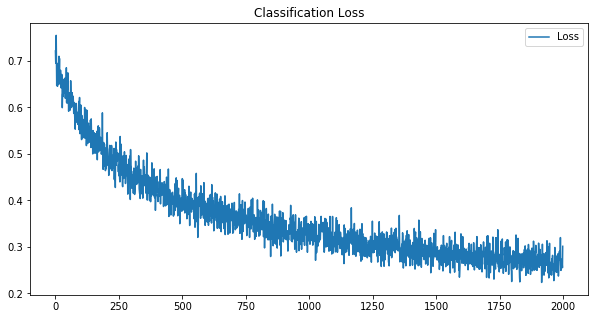

In [0]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

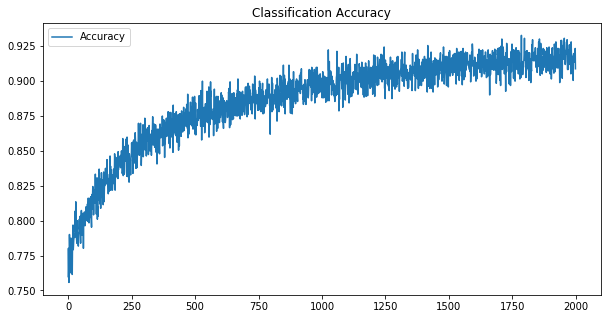

In [0]:
# Plot classification accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()

In [0]:
x, y = dataset.training_set()

# Compute classification accuracy on the training set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 128us/step
Training Accuracy: 10.04%


In [0]:
x, y = dataset.test_set()

# Compute classification accuracy on the test set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

2000/2000 [==============================] - 0s 132us/step
Test Accuracy: 8.45%


# Pseudo Label

In [0]:
# alpha = 0

# def pseudo_loss(alpha):
#   def loss(true, pred):
#     loss = K.categorical_crossentropy(pred, true)
#     return alpha * loss
#   return loss

pseudo_model = build_discriminator_class(build_discriminator_net(img_shape))
# pseudo_model.compile(loss=pseudo_loss(alpha),
#                          metrics=['accuracy'],
#                          optimizer=Adam())
pseudo_model.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [0]:
def pseudo_train(iterations, batch_size, save_interval, alpha_f, t1, t2):

    for iteration in range(iterations):

        # Get unlabeled examples and pseudo labels
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)
        pseudo_label = pseudo_model.predict(imgs_unlabeled)

        # -------------------------
        #  Supervised Training
        # -------------------------

        # Get labeled examples
        imgs_labeled, labels = dataset.batch_labeled(batch_size)

        # Train on labeled examples
        alpha = 1
        loss_labeled, acc_labeled = pseudo_model.train_on_batch(imgs_labeled, labels)

        loss_unlabeled = -1
        acc_unlabeled = -1

        # -------------------------
        #  Supervised Training
        # -------------------------

        # Set alpha
        if iteration < t1: alpha = 0
        else:
            if t1 <= iteration < t2: alpha = (iteration - t1)/(t2 - t1) * alpha_f
            else: alpha = alpha_f

            # Train on unlabeled examples
            loss_unlabeled, acc_unlabeled = pseudo_model.train_on_batch(imgs_unlabeled, pseudo_label)

        if (iteration + 1) % save_interval == 0:

          # Save losses
          losses_pseudo_labeled.append(loss_labeled)
          losses_pseudo_unlabeled.append(loss_unlabeled)
          losses_pseudo.append(loss_labeled + alpha * loss_unlabeled)
          accs_pseudo_labeled.append(acc_labeled)
          accs_pseudo_unlabeled.append(acc_unlabeled)
          accs_pseudo.append((acc_labeled + alpha*acc_unlabeled)/(1 + alpha))
          iteration_checkpoints.append(iteration + 1)

          # Output training progress
          print(
              "%d [supervised loss: %.4f, acc: %.2f%%] [unsupervised loss: %.4f, acc: %.2f%%]"
              % (iteration + 1, loss_labeled, 100 * acc_labeled, 
                  loss_unlabeled, 100 * acc_unlabeled))
          
          pseudo_model.save("./models/models-label-" + str(num_labeled) + "/pseudo-" + str(iteration+1) + ".h5")
          file1 = "./losses/losses-label-" + str(num_labeled) + "/p_supervised_losses.json"
          file2 = "./losses/losses-label-" + str(num_labeled) + "/p_unsupervised_losses.json"
          file3 = "./losses/losses-label-" + str(num_labeled) + "/p_losses.json"
          with open(file1, 'w') as json_file:
                json.dump(str(losses_pseudo_labeled), json_file)
          with open(file2, 'w') as json_file:
                json.dump(str(losses_pseudo_unlabeled), json_file)
          with open(file3, 'w') as json_file:
                json.dump(str(losses_pseudo), json_file)

In [194]:
# Set hyperparameters
iterations = 8000 # 8000
batch_size = 32
save_interval = 100
alpha_f = 3
t1 = 500 #200
t2 = 1000 # 600

# num_labeled = 960  # Number of labeled examples to use (rest will be used as unlabeled)

losses_pseudo_labeled = []
losses_pseudo_unlabeled = []
losses_pseudo = []
accs_pseudo_labeled = []
accs_pseudo_unlabeled = []
accs_pseudo = []
iteration_checkpoints = []

dataset = Dataset(num_labeled)
discriminator_class.trainable = True

starttime = time.clock()

# Train the SGGAN for the specified number of iterations
pseudo_train(iterations, batch_size, save_interval, alpha_f, t1, t2)

endtime = time.clock()
print("Training time: %.4fs" % (endtime - starttime))

100 [supervised loss: 0.1635, acc: 96.88%] [unsupervised loss: -1.0000, acc: -100.00%]
100 [supervised loss: 0.1635, acc: 96.88%] [unsupervised loss: -1.0000, acc: -100.00%]
200 [supervised loss: 0.3721, acc: 84.38%] [unsupervised loss: -1.0000, acc: -100.00%]
200 [supervised loss: 0.3721, acc: 84.38%] [unsupervised loss: -1.0000, acc: -100.00%]
300 [supervised loss: 0.1351, acc: 96.88%] [unsupervised loss: -1.0000, acc: -100.00%]
300 [supervised loss: 0.1351, acc: 96.88%] [unsupervised loss: -1.0000, acc: -100.00%]
400 [supervised loss: 0.1369, acc: 93.75%] [unsupervised loss: -1.0000, acc: -100.00%]
400 [supervised loss: 0.1369, acc: 93.75%] [unsupervised loss: -1.0000, acc: -100.00%]
500 [supervised loss: 0.0381, acc: 100.00%] [unsupervised loss: -1.0000, acc: -100.00%]
500 [supervised loss: 0.0381, acc: 100.00%] [unsupervised loss: -1.0000, acc: -100.00%]
600 [supervised loss: 0.2085, acc: 93.75%] [unsupervised loss: 0.7943, acc: 78.12%]
600 [supervised loss: 0.2085, acc: 93.75%] [

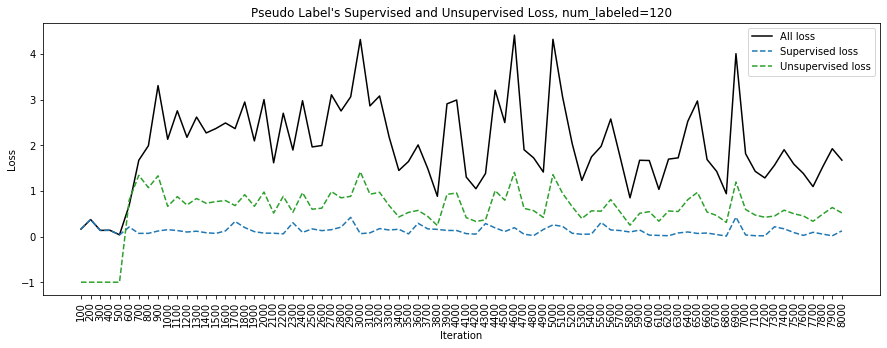

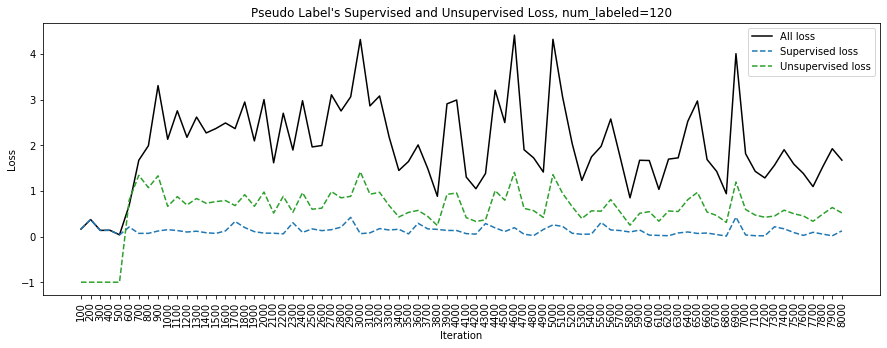

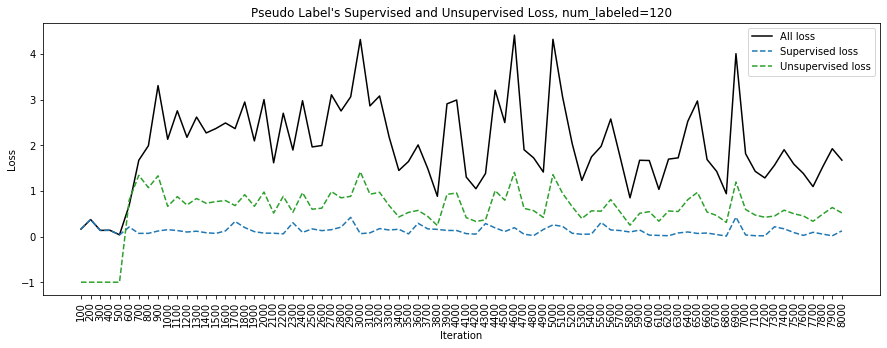

In [195]:
plot_pseudo_supervised_losses = np.array(losses_pseudo_labeled)
plot_pseudo_unsupervised_losses = np.array(losses_pseudo_unlabeled)
plot_pseudo_all_losses = np.array(losses_pseudo)

# Plot losses
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, plot_pseudo_all_losses, label="All loss", color='black')
plt.plot(iteration_checkpoints, plot_pseudo_supervised_losses, label="Supervised loss", color='tab:blue', linestyle='dashed')
plt.plot(iteration_checkpoints, plot_pseudo_unsupervised_losses, label="Unsupervised loss", color='tab:green', linestyle='dashed')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Pseudo Label's Supervised and Unsupervised Loss, num_labeled=%d" % num_labeled)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [196]:
x, y = dataset.training_set()

# tmodel = load_model("./models/models-label-" + str(num_labeled) + "/pseudo-8000.h5")
tmodel = build_discriminator_class(build_discriminator_net(img_shape))
tmodel.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/pseudo-8000.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

9600/9600 [==============================] - 5s 533us/step
Training Accuracy: 48.99%
Training Accuracy: 48.99%
Training Accuracy: 48.99%


In [197]:
x, y = dataset.test_set()

# tmodel = load_model("./models/models-label-" + str(num_labeled) + "/pseudo-6000.h5")
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/pseudo-5900.h5", by_name=False)

_, accuracy = tmodel.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

2400/2400 [==============================] - 0s 190us/step
Test Accuracy: 46.88%
Test Accuracy: 46.88%
Test Accuracy: 46.88%


2400/2400 [==============================] - 0s 183us/step
0.5329166666666667
0.5329166666666667
0.5329166666666667


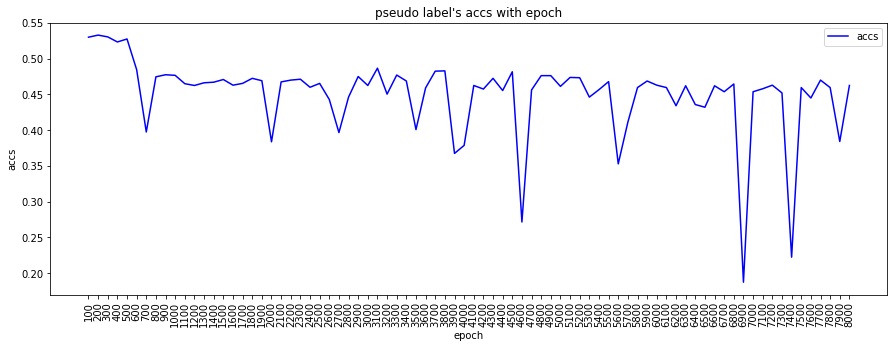

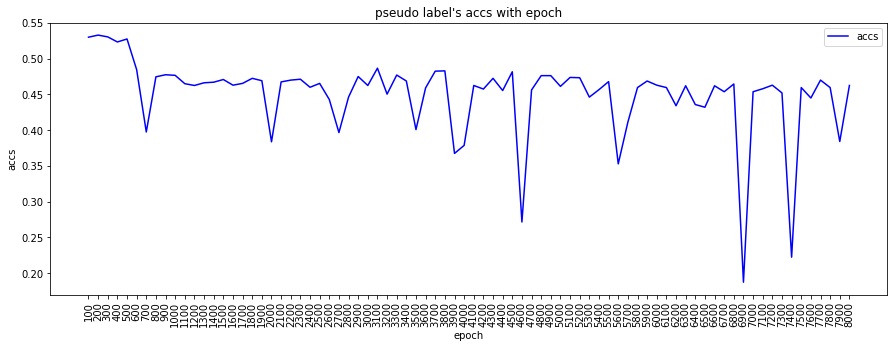

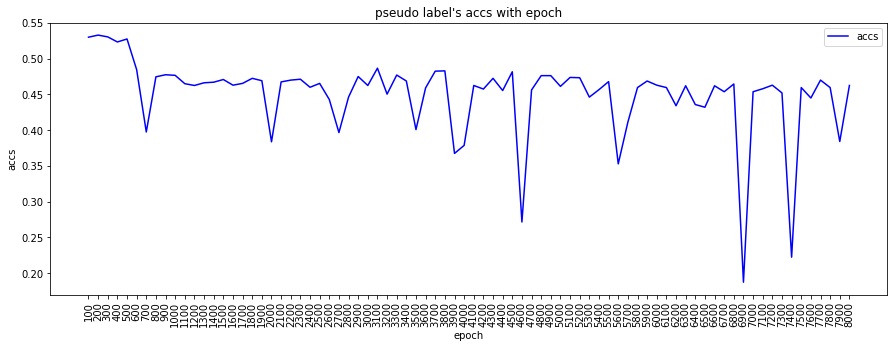

In [198]:
accs = []
tx = [x for x in range(100,8100,100)]
acc_max = [0,0]

for e in tx:
  # tmodel = load_model("./models/models-label-" + str(num_labeled) + "/pseudo-"+ str(e) +".h5")
  tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/pseudo-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("pseudo label's accs with epoch")
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

In [0]:
for acc in accs:
  print(acc)

# Mean Teacher

In [0]:
student = build_discriminator_class(build_discriminator_net(img_shape))
teacher = build_discriminator_class(build_discriminator_net(img_shape))
student.compile(loss='categorical_crossentropy', 
                metrics=['accuracy'], 
                optimizer=Adam())
teacher.compile(loss='categorical_crossentropy', 
                metrics=['accuracy'], 
                optimizer=Adam())

In [0]:
def mean_teacher_train(iterations, batch_size, save_interval, alpha):

    for iteration in range(iterations):

        # -------------------------
        #  Train the model
        # -------------------------

        # Get labeled examples
        imgs_labeled, labels = dataset.batch_labeled(batch_size)

        # Get unlabeled examples
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # Train on labeled examples
        loss_labeled_classification, acc_labeled_classification = student.train_on_batch(imgs_labeled, labels)
        pred_teacher_labeled = teacher.predict(imgs_labeled)
        loss_labeled_consistency, acc_labeled_consistency = student.train_on_batch(imgs_labeled, pred_teacher_labeled)

        # Train on unlabeled examples
        pred_teacher_unlabeled = teacher.predict(imgs_unlabeled)
        loss_unlabeled_consistency, acc_unlabeled_consistency = student.train_on_batch(imgs_unlabeled, pred_teacher_unlabeled)

        # Update teacher model
        teacher_weights_this = teacher.get_weights()
        student_weights_this = student.get_weights()
        for i in range(len(teacher_weights_this)):
          teacher_weights_this[i] = alpha * teacher_weights_this[i] + (1-alpha) * student_weights_this[i]
        # teacher_weights_this = alpha * teacher_weights_this + (1-alpha) * student_weights_this
        teacher_weights_last = teacher_weights_this
        teacher.set_weights(teacher_weights_this)

        if (iteration + 1) % save_interval == 0:

          # Save losses
          supervised_losses.append(loss_labeled_classification)
          unsupervised_losses.append(loss_labeled_consistency + loss_unlabeled_consistency)
          labeled_consistency_costs.append(loss_labeled_consistency)
          unlabeled_consistency_costs.append(loss_unlabeled_consistency)
          accs_supervised.append(acc_labeled_classification)
          accs_unsupervised.append((acc_labeled_consistency + acc_unlabeled_consistency)/2.0)
          accs_labeled_consistency.append(acc_labeled_consistency)
          accs_unlabeled_consistency.append(acc_unlabeled_consistency)

          iteration_checkpoints.append(iteration + 1)

          # Output training progress
          print(
              "%d [supervised loss: %.4f, acc: %.2f%%] [unsupervised loss: %.4f, acc: %.2f%%] [labeled consistency loss: %.4f, acc:acc: %.2f%%] [unlabeled consistency loss: %.4f, acc: %.2f%%]"
              % (iteration + 1, loss_labeled_classification, 100 * acc_labeled_classification, 
                 loss_labeled_consistency + loss_unlabeled_consistency, 100 * ((acc_labeled_consistency + acc_unlabeled_consistency)/2.0), 
                 loss_labeled_consistency, 100 * acc_labeled_consistency, 
                  loss_unlabeled_consistency, 100 * acc_unlabeled_consistency))
          
          student.save("./models/models-label-" + str(num_labeled) + "/student-" + str(iteration+1) + ".h5")
          teacher.save("./models/models-label-" + str(num_labeled) + "/teacher-" + str(iteration+1) + ".h5")
          file1 = "./losses/losses-label-" + str(num_labeled) + "/mt_supervised_losses.json"
          file2 = "./losses/losses-label-" + str(num_labeled) + "/mt_unsupervised_losses.json"
          file3 = "./losses/losses-label-" + str(num_labeled) + "/mt_labeled_consistency_costs.json"
          file4 = "./losses/losses-label-" + str(num_labeled) + "/mt_unlabeled_consistency_costs.json"
          with open(file1, 'w') as json_file:
                json.dump(str(supervised_losses), json_file)
          with open(file2, 'w') as json_file:
                json.dump(str(unsupervised_losses), json_file)
          with open(file3, 'w') as json_file:
                json.dump(str(labeled_consistency_costs), json_file)
          with open(file4, 'w') as json_file:
                json.dump(str(unlabeled_consistency_costs), json_file)

In [200]:
# Set hyperparameters
iterations = 12000 # 8000
batch_size = 32
save_interval = 100
alpha = 0.5

# num_labeled = 960  # Number of labeled examples to use (rest will be used as unlabeled)

supervised_losses = [] # classification cost
unsupervised_losses = [] # consistency cost
labeled_consistency_costs = []
unlabeled_consistency_costs = []
accs_supervised = []
accs_unsupervised = []
accs_labeled_consistency = []
accs_unlabeled_consistency = []
iteration_checkpoints = []

dataset = Dataset(num_labeled)
discriminator_class.trainable = True

starttime = time.clock()

# Train the mean teacher for the specified number of iterations
mean_teacher_train(iterations, batch_size, save_interval, alpha)

endtime = time.clock()
print("Training time: %.4fs" % (endtime - starttime))

100 [supervised loss: 0.0916, acc: 100.00%] [unsupervised loss: 1.2664, acc: 85.94%] [labeled consistency loss: 0.3616, acc:acc: 93.75%] [unlabeled consistency loss: 0.9047, acc: 78.12%]
100 [supervised loss: 0.0916, acc: 100.00%] [unsupervised loss: 1.2664, acc: 85.94%] [labeled consistency loss: 0.3616, acc:acc: 93.75%] [unlabeled consistency loss: 0.9047, acc: 78.12%]
100 [supervised loss: 0.0916, acc: 100.00%] [unsupervised loss: 1.2664, acc: 85.94%] [labeled consistency loss: 0.3616, acc:acc: 93.75%] [unlabeled consistency loss: 0.9047, acc: 78.12%]
200 [supervised loss: 0.0822, acc: 96.88%] [unsupervised loss: 0.9514, acc: 90.62%] [labeled consistency loss: 0.1540, acc:acc: 100.00%] [unlabeled consistency loss: 0.7974, acc: 81.25%]
200 [supervised loss: 0.0822, acc: 96.88%] [unsupervised loss: 0.9514, acc: 90.62%] [labeled consistency loss: 0.1540, acc:acc: 100.00%] [unlabeled consistency loss: 0.7974, acc: 81.25%]
200 [supervised loss: 0.0822, acc: 96.88%] [unsupervised loss: 0.

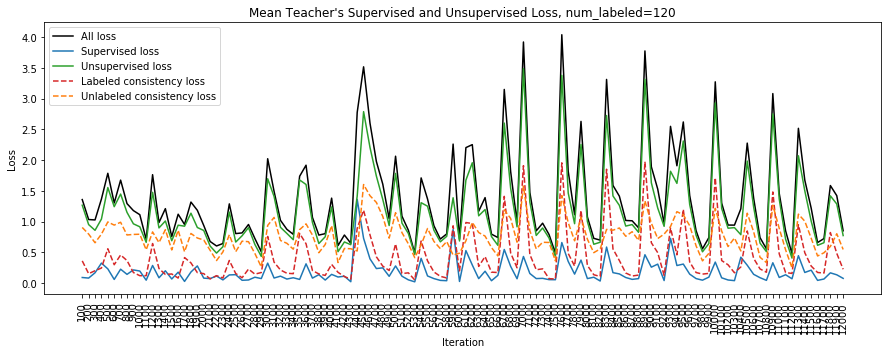

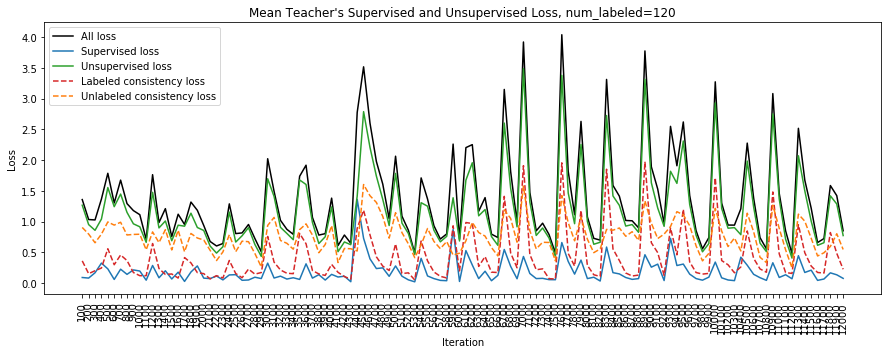

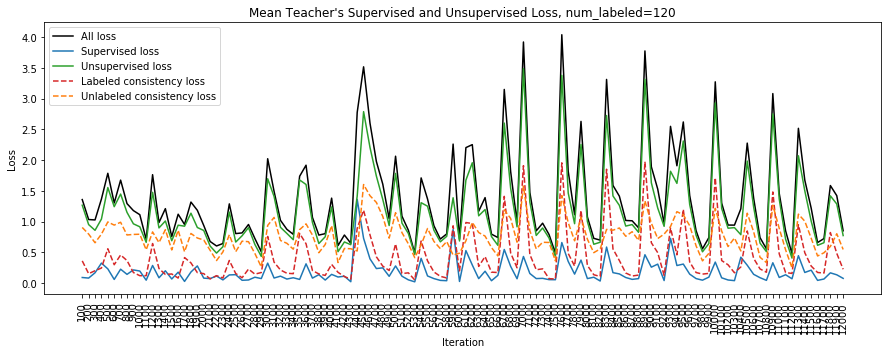

In [201]:
plot_supervised_losses = np.array(supervised_losses)
plot_unsupervised_losses = np.array(unsupervised_losses)
plot_labeled_consistency_costs = np.array(labeled_consistency_costs)
plot_unlabeled_consistency_costs = np.array(unlabeled_consistency_costs)
plot_all_losses = np.array(supervised_losses)+np.array(unsupervised_losses)

# Plot losses
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, plot_all_losses, label="All loss", color='black')
plt.plot(iteration_checkpoints, plot_supervised_losses, label="Supervised loss", color='tab:blue')
plt.plot(iteration_checkpoints, plot_unsupervised_losses, label="Unsupervised loss", color='tab:green')
plt.plot(iteration_checkpoints, plot_labeled_consistency_costs, label="Labeled consistency loss", color='tab:red', linestyle='dashed')
plt.plot(iteration_checkpoints, plot_unlabeled_consistency_costs, label="Unlabeled consistency loss", color='tab:orange', linestyle='dashed')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Mean Teacher's Supervised and Unsupervised Loss, num_labeled=%d" % num_labeled)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [202]:
x, y = dataset.training_set()

# tmodel = load_model("./models/models-label-" + str(num_labeled) + "/teacher-4700.h5")
tmodel = build_discriminator_class(build_discriminator_net(img_shape))
tmodel.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/teacher-8000.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

9600/9600 [==============================] - 5s 549us/step
Training Accuracy: 49.18%
Training Accuracy: 49.18%
Training Accuracy: 49.18%


In [0]:
x, y = dataset.test_set()

# tmodel = load_model("./models/models-label-" + str(num_labeled) + "/teacher-8000.h5")
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/teacher-6100.h5", by_name=False)

# Compute classification accuracy on the test set
_, accuracy = tmodel.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

2400/2400 [==============================] - 0s 165us/step
Test Accuracy: 15.58%


2400/2400 [==============================] - 0s 175us/step
0.5054166666666666
0.5054166666666666
0.5054166666666666


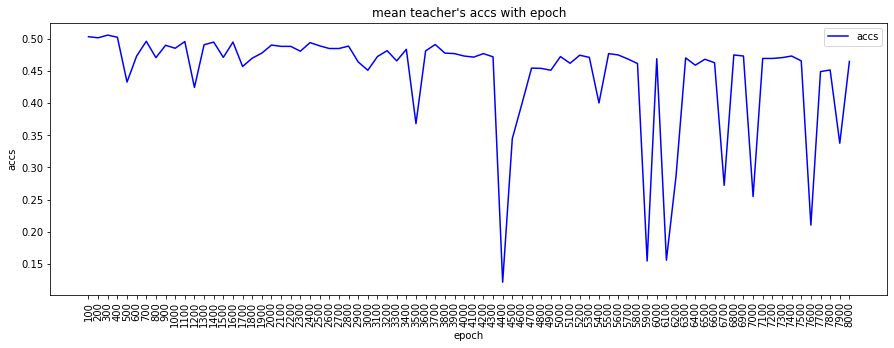

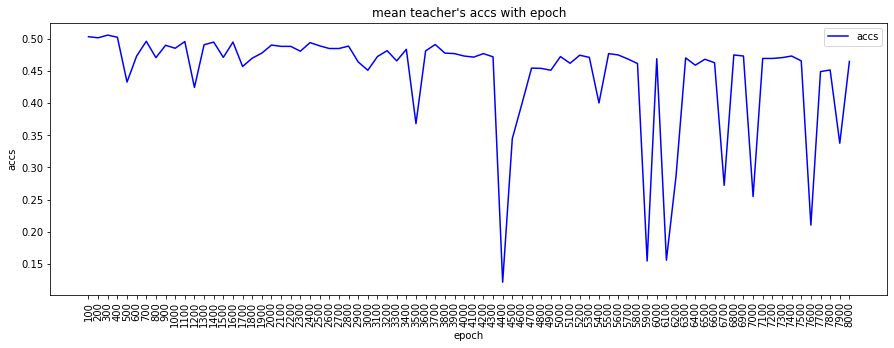

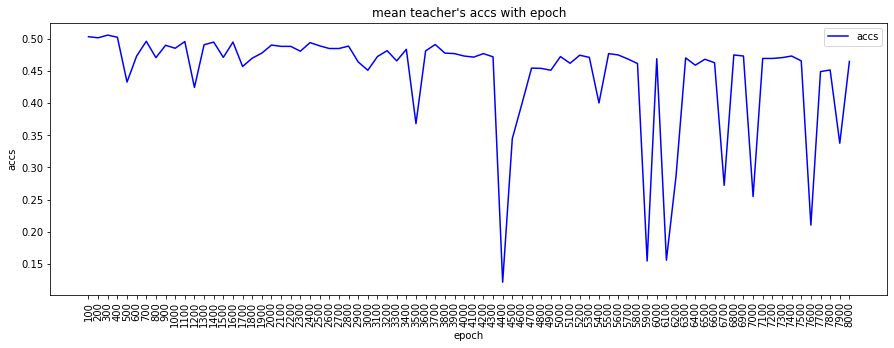

In [204]:
accs = []
tx = [x for x in range(100,8100,100)]
acc_max = [0,0]

for e in tx:
  # tmodel = load_model("./models/models-label-" + str(num_labeled) + "/teacher-"+ str(e) +".h5")
  tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/teacher-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("mean teacher's accs with epoch")
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

In [0]:
for acc in accs:
  print(acc)

0.5029166666666667
0.50125
0.5054166666666666
0.5020833333333333
0.4325
0.47291666666666665
0.49583333333333335
0.47041666666666665
0.4895833333333333
0.485
0.49541666666666667
0.4241666666666667
0.49041666666666667
0.4945833333333333
0.4708333333333333
0.4945833333333333
0.45666666666666667
0.46958333333333335
0.4775
0.49
0.48791666666666667
0.48791666666666667
0.48041666666666666
0.49375
0.48875
0.4845833333333333
0.4845833333333333
0.48833333333333334
0.46375
0.4508333333333333
0.47208333333333335
0.48125
0.46541666666666665
0.48333333333333334
0.36791666666666667
0.48083333333333333
0.49083333333333334
0.4775
0.4766666666666667
0.47291666666666665
0.47125
0.4766666666666667
0.4716666666666667
0.12166666666666667
0.34458333333333335
0.39875
0.45416666666666666
0.45375
0.4508333333333333
0.47208333333333335
0.46166666666666667
0.4741666666666667
0.4708333333333333
0.4
0.4766666666666667
0.47458333333333336
0.4683333333333333
0.46125
0.15458333333333332
0.46875
0.15583333333333332
0.2